# Fine tuning classification example

We will fine-tune an ada classifier to distinguish between the two sports: Baseball and Hockey.

In [21]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import openai

categories = ['rec.sport.baseball', 'rec.sport.hockey']
sports_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)

 ## Data exploration
 The newsgroup dataset can be loaded using sklearn. First we will look at the data itself:

In [4]:
print(sports_dataset['data'][0])

From: dougb@comm.mot.com (Doug Bank)
Subject: Re: Info needed for Cleveland tickets
Reply-To: dougb@ecs.comm.mot.com
Organization: Motorola Land Mobile Products Sector
Distribution: usa
Nntp-Posting-Host: 145.1.146.35
Lines: 17

In article <1993Apr1.234031.4950@leland.Stanford.EDU>, bohnert@leland.Stanford.EDU (matthew bohnert) writes:

|> I'm going to be in Cleveland Thursday, April 15 to Sunday, April 18.
|> Does anybody know if the Tribe will be in town on those dates, and
|> if so, who're they playing and if tickets are available?

The tribe will be in town from April 16 to the 19th.
There are ALWAYS tickets available! (Though they are playing Toronto,
and many Toronto fans make the trip to Cleveland as it is easier to
get tickets in Cleveland than in Toronto.  Either way, I seriously
doubt they will sell out until the end of the season.)

-- 
Doug Bank                       Private Systems Division
dougb@ecs.comm.mot.com          Motorola Communications Sector
dougb@nwu.edu       

In [5]:
sports_dataset.target_names[sports_dataset['target'][0]]


'rec.sport.baseball'

In [7]:
len_all, len_baseball, len_hockey = len(sports_dataset.data), len([e for e in sports_dataset.target if e == 0]), len([e for e in sports_dataset.target if e == 1])
print(f"Total examples: {len_all}, Baseball examples: {len_baseball}, Hockey examples: {len_hockey}")

Total examples: 1197, Baseball examples: 597, Hockey examples: 600


One sample from the baseball category can be seen above. It is an email to a mailing list. We can observe that we have 1197 examples in total, which are evenly split between the two sports.

## Data Preparation
We transform the dataset into a pandas dataframe, with a column for prompt and completion. The prompt contains the email from the mailing list, and the completion is a name of the sport, either hockey or baseball. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [10]:
import pandas as pd

labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
texts = [text.strip() for text in sports_dataset['data']]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

,prompt,completion
0,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,baseball
1,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
2,From: rudy@netcom.com (Rudy Wade)\nSubject: Re...,baseball
3,From: monack@helium.gas.uug.arizona.edu (david...,hockey
4,Subject: Let it be Known\nFrom: <ISSBTL@BYUVM....,baseball


Both baseball and hockey are single tokens. We save the dataset as a jsonl file.

In [11]:
df.to_json("sport1.jsonl", orient='records', lines=True)

### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [ ]:
!pip install --upgrade openai

In [13]:
!openai tools fine_tunes.prepare_data -f sport1.jsonl -q

Analyzing...

- Your file contains 1197 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`. You should also set the `--no_packing` parameter when fine-tuning
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://beta.op

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## Fine-tuning
The tool suggests we run the following command to train the dataset. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. We add `--compute_classification_metrics --classification_positive_class " hockey"` in order to compute the classification metrics.

In [14]:
!openai api fine_tunes.create -t "sport1_prepared_train.jsonl" -v "sport1_prepared_valid.jsonl" --no_packing -m ada --compute_classification_metrics --classification_positive_class " hockey"

Upload progress: 100%|████████████████████| 1.76M/1.76M [00:00<00:00, 1.85Mit/s]
Uploaded file from sport1_prepared_train.jsonl: file-6TJY51ApcI0YzumClqdpyhjk
Upload progress: 100%|███████████████████████| 395k/395k [00:00<00:00, 754kit/s]
Uploaded file from sport1_prepared_valid.jsonl: file-7jmZYAJHneAuzVGlauejsas9
Created fine-tune: ft-T4UkKqMbMM1Eu56q8ks6g8u5
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2021-07-26 12:13:52] Created fine-tune: ft-T4UkKqMbMM1Eu56q8ks6g8u5
[2021-07-26 12:13:57] Fine-tune enqueued. Queue number: 0
[2021-07-26 12:14:00] Fine-tune started
[2021-07-26 12:16:56] Completed epoch 1/4
[2021-07-26 12:18:37] Completed epoch 2/4
[2021-07-26 12:20:29] Completed epoch 3/4
[2021-07-26 12:22:31] Completed epoch 4/4
[2021-07-26 12:24:02] Uploaded model: ada:ft-openai-internal-2021-07-26-11-24-00
[2021-07-26 12:24:06] Uploaded result file: file-ForZ3pSAQ6db7bxmMJhw6GEo
[2021-07-26 12:24:07] Fine-tu

The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-internal-2021-07-26-11-24-00`, which we can use for doing inference.

### [Advanced] Results and expected model performance
We can now download the results file to observe the expected performance on a held out validation set.

In [15]:
!openai api fine_tunes.results -i ft-T4UkKqMbMM1Eu56q8ks6g8u5 > result.csv

In [17]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0,validation_loss,validation_sequence_accuracy,validation_token_accuracy
926,927,3108476,3708,0.022579,1.0,1.0,0.995833,1.0,0.991667,0.99875,0.998909,0.995816,NaN,NaN,NaN


The accuracy reaches 99.6%. On the plot below we can see how accuracy on the validation set increases during the training run. 

<AxesSubplot:>

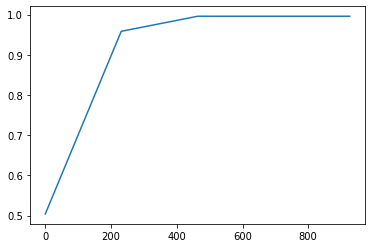

In [18]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## Using the model
We can now call the model to get the predictions.

In [19]:
test = pd.read_json('sport1_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
1,From: smorris@venus.lerc.nasa.gov (Ron Morris ...,hockey
2,From: golchowy@alchemy.chem.utoronto.ca (Geral...,hockey
3,From: krattige@hpcc01.corp.hp.com (Kim Krattig...,baseball
4,From: warped@cs.montana.edu (Doug Dolven)\nSub...,baseball


In [30]:
ft_model = 'ada:ft-openai-internal-2021-07-26-11-24-00'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']


' hockey'

To get the log probabilities, we can specify logprobs parameter on the completion request

In [29]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7ff86896c728> JSON: {
  " baseball": -6.3311357,
  " hockey": -0.0018503045
}

We can see that the model predicts hockey as a lot more likely than baseball, which is the correct prediction. By requesting log_probs, we can see the prediction (log) probability for each class.

### Generalization
Interestingly, our fine-tuned classifier is quite versatile. Despite being trained on emails to different mailing lists, it also successfully predicts tweets.

In [28]:
sample_hockey_tweet = """Thank you to the 
@Canes
 and all you amazing Caniacs that have been so supportive! You guys are some of the best fans in the NHL without a doubt! Really excited to start this new chapter in my career with the 
@DetroitRedWings
 !!"""
res = openai.Completion.create(model=ft_model, prompt=sample_hockey_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

In [31]:
sample_baseball_tweet="""BREAKING: The Tampa Bay Rays are finalizing a deal to acquire slugger Nelson Cruz from the Minnesota Twins, sources tell ESPN."""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' baseball'